<a href="https://colab.research.google.com/github/John-Akech/Time-Series-Forecasting/blob/master/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook
# This notebook predicts PM2.5 levels in Beijing using a bidirectional LSTM model.
# It includes data exploration, preprocessing, model building, and Kaggle submission.
# The code is organized into clear sections with detailed comments for beginners.

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import mean_squared_error
from keras.layers import BatchNormalization
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import os

# Setup Kaggle API and Download Data

In [3]:
# Install Kaggle API version 1.5.8 for compatibility
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8

# Setup Kaggle credentials and download the dataset
# Creates a directory for credentials, writes the API key, and sets permissions
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"johnakec","key":"fd602a332d8823cffa98235ebe243990"}')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Download the competition dataset and unzip it to '/content/data'
!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025
!mkdir -p /content/data
!unzip -qo 'assignment-1-time-series-forecasting-may-2025.zip' -d '/content/data'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=604b3ddfe525b2d3223c8d6578b01127b9b42b47f4921a71041ed2a01b6e72cb
  Stored in directory: /root/.cache/pip/wheels/b5/23/bd/d33cbf399584fa44fa049711892d333954a50ed4b86948109e
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5
  0% 0.00/839k [00:00<?, ?B/s]
100% 839k/839k [00:00<00:00, 75.5MB/s]


# Load Datasets

In [4]:
# Load Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load training and test data
train = pd.read_csv('/content/drive/MyDrive/DeveloperHub/Datasets/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DeveloperHub/Datasets/test.csv')

Mounted at /content/drive


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [5]:
# Inspecting the first and the last few rows of the dataset to understand its structure.
print("First 5 rows of training data:")
print(train.head())
print("\nLast 5 rows of training data:")
print(train.tail())

First 5 rows of training data:
   No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353 -0.137667   
1   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353 -0.137667   
2   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353 -0.137667   
3   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353 -0.137667   
4   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353 -0.137667   

              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
0  2010-01-01 00:00:00  1.448138 -0.732019 -0.522096    NaN  
1  2010-01-01 01:00:00  1.448138 -0.732019 -0.522096    NaN  
2  2010-01-01 02:00:00  1.448138 -0.732019 -0.522096    NaN  
3  2010-01-01 03:00:00  1.448138 -0.732019 -0.522096    NaN  
4  2010-01-01 04:00:00  1.448138 -0.732019 -0.522096    NaN  

Last 5 rows of training data:
          No      DEWP      TEMP      PRES       Iws        Is        Ir  \
30671  30672  1.467633  0.946961 -2.088668 -0.415099 -0.069353  2.687490   

In [6]:
# Check the size of the datasets
print("\nTrain shape:", train.shape, "Test shape:", test.shape)


Train shape: (30676, 12) Test shape: (13148, 11)


In [7]:
# Check for the duplicates
print("\nDuplicate rows in train:", train.duplicated().sum())
print("\nDuplicate rows in test:", test.duplicated().sum())


Duplicate rows in train: 0

Duplicate rows in test: 0


In [8]:
# Display the information
print("\nInfo for Training Data:")
print(train.info())


Info for Training Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB
None


In [9]:
# Display columns of the training and the test datasets
print("\nColumns in Training Data:")
print(train.columns)
print("\nColumns in Test Data:")
print(test.columns)


Columns in Training Data:
Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

Columns in Test Data:
Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv'],
      dtype='object')


In [10]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [11]:
# Check for missing values
print("\nMissing values in train:\n", train.isnull().sum())
print("\nMissing values in test:\n", test.isnull().sum())


Missing values in train:
 No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64

Missing values in test:
 No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
dtype: int64


In [12]:
# Handle the missing values using the best method for time series forecasting
# In this example, missing values are filled with the mean.
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [13]:
# Basic summary statistics
print("\nSummary Statistics for Training Data:")
print(train.describe())


Summary Statistics for Training Data:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1

# Visualisations

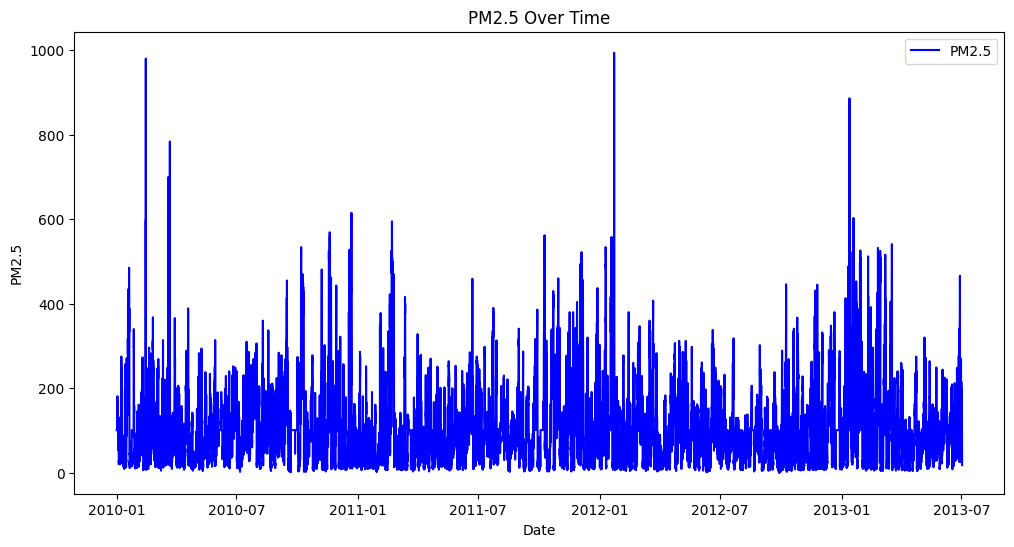

In [14]:
# Visualize PM2.5 over time
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['pm2.5'], label='PM2.5', color='blue')
plt.title('PM2.5 Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

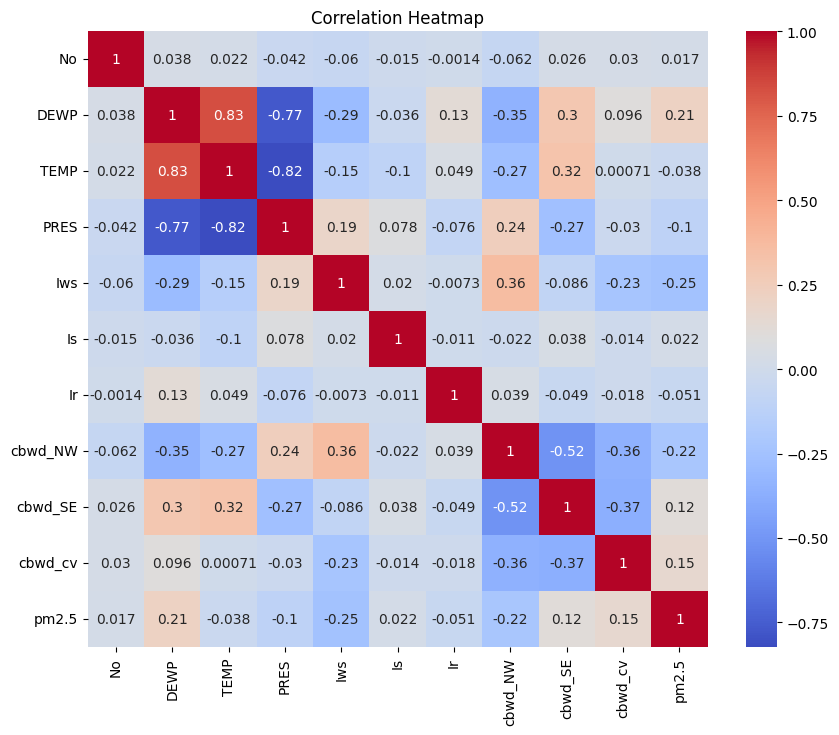

In [15]:
# Heatmap to understand the relationship in the datasets
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [16]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [17]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [30]:
# Define Bidirectional LSTM model
model = Sequential([
    Bidirectional(LSTM(64, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


# Compile the model with RMSE metric
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE
)

# Show the model structure
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,201 (168.75 KB)

 Trainable params: 42,881 (167.50 KB)

 Non-trainable params: 320 (1.25 KB)

In [31]:
# Define early stopping
early_stop = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [32]:
# Train the model with validation split
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - lambda: 133.6521 - loss: 18003.3887 - val_lambda: 119.0644 - val_loss: 16782.2266
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - lambda: 122.7632 - loss: 15242.9521 - val_lambda: 101.1513 - val_loss: 12676.6182
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - lambda: 104.3161 - loss: 11065.9414 - val_lambda: 78.7337 - val_loss: 8069.4727
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - lambda: 92.2793 - loss: 8670.0186 - val_lambda: 75.0849 - val_loss: 7084.0542
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - lambda: 89.3930 - loss: 8117.3628 - val_lambda: 72.5934 - val_loss: 6514.8247
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - lambda: 86.8257 - loss: 7700.2485 - val_lambda: 69.9148 - val_loss: 6085.0332
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - lambda: 84.6367 - loss: 7303.7715 - val_lambda: 67.5616 - val_loss: 5622.9663
Epoch 8/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - l

959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


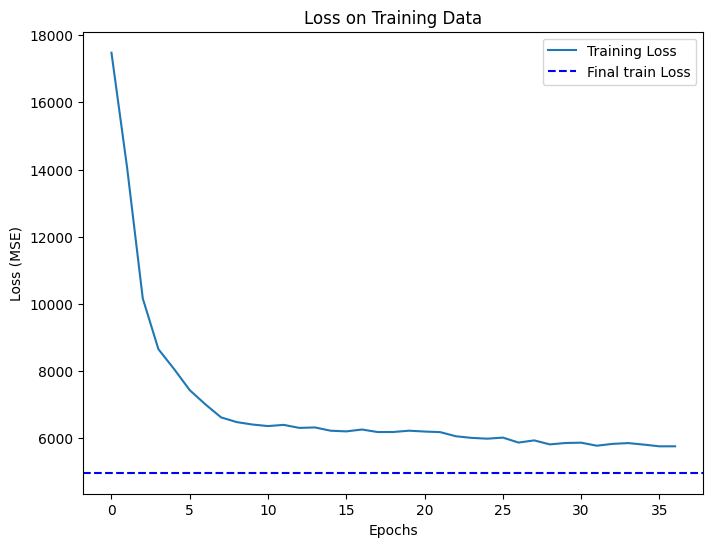

Final Training Loss (MSE): 4977.354701923434


In [33]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [34]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/DeveloperHub/Datasets/subm_fixed.csv', index=False)

# Validate Before Submitting
print(os.path.exists('/content/drive/MyDrive/DeveloperHub/Datasets/subm_fixed.csv'))

# Submit to Kaggle
!kaggle competitions submit -c assignment-1-time-series-forecasting-may-2025 -f /content/drive/MyDrive/DeveloperHub/Datasets/subm_fixed.csv -m "Enhanced LSTM Submission"

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
True
100% 296k/296k [00:00<00:00, 786kB/s]
400 - Bad Request
